# **Skenario 3 - CNN MobileNetV2**

Skenario 3 menggunakan model Convolutional Neural Network (CNN) dengan arsitektur MobileNetV2 untuk melakukan klasifikasi pada data citra otak.

---

## 1. Import packages

Impor semua pustaka dan modul yang dibutuhkan untuk pemrosesan data, visualisasi, pembuatan model, dan pelatihan model

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import pickle

# Scikit-learn imports
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import KFold

# TensorFlow and Keras imports
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, models, optimizers

## 2. Data Preparation

### 2.1 Load dan Eksplorasi Data
Load dan proses data `image_selected.npz`

In [2]:
def load_and_preprocess_data():
    base_dir = r"D:\Users\RESA\Coding\Alzheimer-Classification-with-CNN-SVM\Notebook\Preprocessing\image_selected.npz"
    
    # Muat data dari file NPZ
    loaded_data = np.load(base_dir, allow_pickle=True)
    loaded_combined_slices = loaded_data[list(loaded_data.keys())[0]]

    # Persiapkan daftar X dan Y
    X = []
    Y = []

    # Buat pemetaan label untuk tiap kelas 
    label_mapping = {'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3}

    # Iterasi melalui data yang dimuat
    for label, plane_slices in loaded_combined_slices.item().items():
        for plane, slices in plane_slices.items():
            for selected_slice in slices:
                position, original_slice = selected_slice

                # Tambahkan data ke X dan Y tanpa mengubah ukuran
                X.append(original_slice)
                Y.append(label_mapping[label])

    # Konversi daftar ke array NumPy
    X = np.array(X) / 255.0  # Normalisasi
    Y = np.array(Y)

    # Konversi label ke format kategorikal
    Y = to_categorical(Y, num_classes=len(set(Y)))

    return X, Y

In [3]:
# Panggil fungsi dan simpan ke X, Y
X, Y = load_and_preprocess_data()

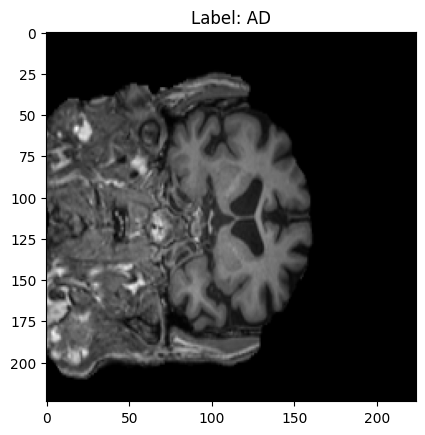

In [4]:
index_to_visualize = 3
image_to_visualize = X[index_to_visualize]
label_to_visualize = Y[index_to_visualize]

class_names = {0: 'AD', 1: 'CN', 2: 'EMCI', 3: 'LMCI'}
label_to_visualize = class_names[np.argmax(label_to_visualize)]

plt.imshow(image_to_visualize)
plt.title(f"Label: {label_to_visualize}")
plt.imshow(image_to_visualize, cmap='gray')


In [5]:
unique_labels, counts = np.unique(np.argmax(Y, axis=1), return_counts=True)
class_distribution = dict(zip(tuple(unique_labels), counts))

print("Distribusi Kelas setelah One-Hot Encoding:")
print(class_distribution)

Distribusi Kelas setelah One-Hot Encoding:
{0: 1800, 1: 1800, 2: 1800, 3: 1800}


### 2.2 Pembagian Data
Data dibagi dengan rasio 80:20 

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cek shape dan jumlah data

In [7]:
print("Dimensi X_train:", X_train.shape)
print("Dimensi Y_train:", Y_train.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi Y_test:", Y_test.shape)

Dimensi X_train: (5760, 224, 224)
Dimensi Y_train: (5760, 4)
Dimensi X_test: (1440, 224, 224)
Dimensi Y_test: (1440, 4)


In [8]:
X_train_rgb = np.expand_dims(X_train, axis=-1)
X_test_rgb = np.expand_dims(X_test, axis=-1)

In [9]:
X_train_rgb = np.repeat(X_train_rgb, 3, axis=-1)
X_test_rgb = np.repeat(X_test_rgb, 3, axis=-1)

In [10]:
print("Dimensi X_train_rgb:", X_train_rgb.shape)
print("Dimensi Y_train:", Y_train.shape)
print("Dimensi X_test_rgb:", X_test_rgb.shape)
print("Dimensi Y_test:", Y_test.shape)

Dimensi X_train_rgb: (5760, 224, 224, 3)
Dimensi Y_train: (5760, 4)
Dimensi X_test_rgb: (1440, 224, 224, 3)
Dimensi Y_test: (1440, 4)


In [11]:
print("Jumlah sampel dalam X_train:", len(X_train_rgb))
print("Jumlah sampel dalam Y_train:", len(Y_train))
print("Jumlah sampel dalam X_test:", len(X_test_rgb))
print("Jumlah sampel dalam Y_test:", len(Y_test))

Jumlah sampel dalam X_train: 5760
Jumlah sampel dalam Y_train: 5760
Jumlah sampel dalam X_test: 1440
Jumlah sampel dalam Y_test: 1440


## 3. Buat dan Konfigurasi Model
Arsitektur yang digunakan yaitu MobileNetV2 sebagai bagian dari transfer learning yaitu arsitektur yang sudah dilatih dengan data ImageNet

In [12]:
%%time
inputs = Input(shape=(224, 224, 3))

# Use MobileNetV2 as a layer in your model
def create_model():
    inputs = Input(shape=(224, 224, 3))
    base_model = MobileNetV2(
        weights='imagenet',
        input_tensor=inputs,
        include_top=False,
        input_shape=(224, 224, 3)
    )
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs, outputs)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

CPU times: total: 0 ns
Wall time: 4.99 ms


In [13]:
# Use MobileNetV2 as a layer in your model
model = create_model()

# Display the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

## 4. Training Model
Latih model dengan data `X_train dan Y_train` dan menguji kinerja model pada data validasi `X_test dan Y_test`, setelah pelatihan nanti model akan menyimpan riwayatnya ke dalam `h_model`

In [14]:
# Fine-tuning
EPOCH = 25
BATCH_SIZE = 16
h_model = model.fit(X_train_rgb, Y_train, epochs=EPOCH, validation_data=(X_test_rgb, Y_test), batch_size=BATCH_SIZE)

Epoch 1/25
360/360 [==============================] - 81s 223ms/step - loss: 1.5093 - accuracy: 0.3218 - val_loss: 1.2184 - val_accuracy: 0.4333
Epoch 2/25
360/360 [==============================] - 81s 224ms/step - loss: 1.2145 - accuracy: 0.4431 - val_loss: 1.1188 - val_accuracy: 0.5167
Epoch 3/25
360/360 [==============================] - 80s 222ms/step - loss: 1.0845 - accuracy: 0.5240 - val_loss: 1.1845 - val_accuracy: 0.4965
Epoch 4/25
360/360 [==============================] - 80s 223ms/step - loss: 1.0070 - accuracy: 0.5586 - val_loss: 1.0401 - val_accuracy: 0.5417
Epoch 5/25
360/360 [==============================] - 77s 214ms/step - loss: 0.9117 - accuracy: 0.6115 - val_loss: 0.9534 - val_accuracy: 0.6146
Epoch 6/25
360/360 [==============================] - 77s 215ms/step - loss: 0.8087 - accuracy: 0.6636 - val_loss: 0.9647 - val_accuracy: 0.6007
Epoch 7/25
360/360 [==============================] - 79s 221ms/step - loss: 0.7219 - accuracy: 0.6993 - val_loss: 0.9375 - val_ac

## 5. Testing

### 5.1 Menilai model pada data uji

In [15]:
# Evaluasi model menggunakan data uji NumPy
evaluation_result = model.evaluate(X_test_rgb, Y_test, verbose=1)

# Menampilkan hasil evaluasi
print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

# Prediksi menggunakan data uji
predictions = model.predict(X_test_rgb)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

print('Label Sebenarnya : ', np.argmax(Y_test, axis=1))
print('Label Prediksi : ', predicted_labels)

45/45 [==============================] - 16s 340ms/step - loss: 1.2793 - accuracy: 0.7201
Loss: 1.279334545135498
Accuracy: 0.7201389074325562
Label Sebenarnya :  [1 1 2 ... 3 1 1]
Label Prediksi :  [0 1 2 ... 0 3 1]


### 5.2 Visualisasi beberapa gambar dari data uji
Membuat visualisasi dari beberapa contoh hasil prediksi model pada data test

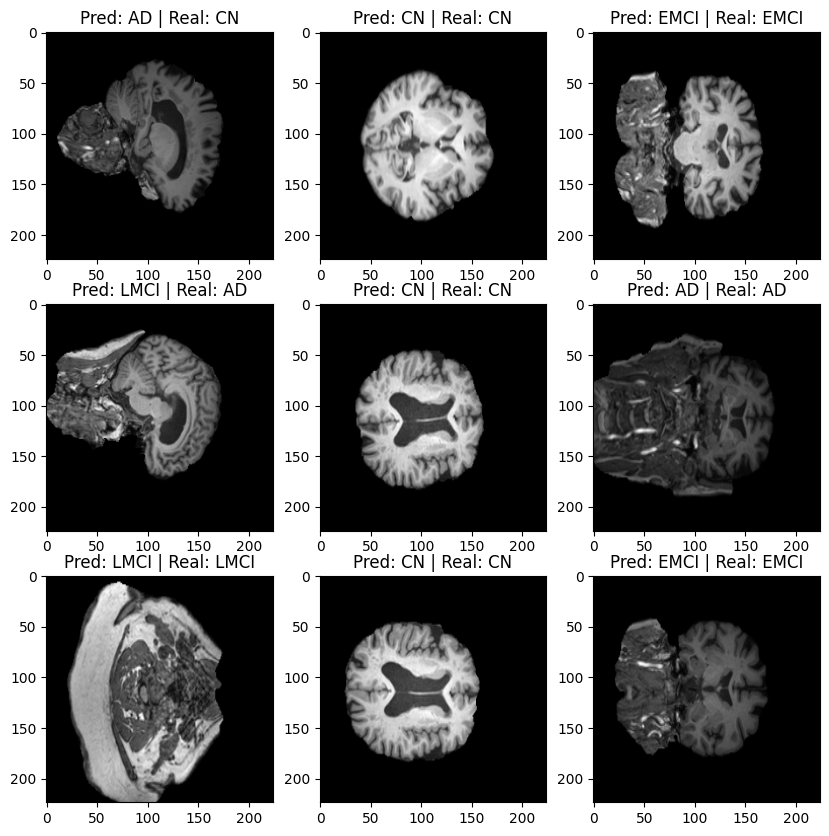

In [16]:
class_names = ["AD", "CN", "EMCI", "LMCI"]

plt.figure(figsize=(10, 10))
for i in range(min(9, len(X_test))):
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(X_test[i].astype("int64"))
    plt.imshow(X_test[i],cmap="gray")
    
    # Dapatkan label prediksi dan label sebenarnya
    true_label = np.argmax(Y_test[i])
    plt.title("Pred: " + class_names[predicted_labels[i]] + " | Real: " + class_names[true_label])

plt.show()

## 6. Evaluasi

### 6.1 Matriks specificity dan sensitivity

In [17]:
from keras import backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', specificity, sensitivity])

Evaluasi model pada data train

In [18]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_train_rgb, Y_train)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

180/180 [==============================] - 64s 350ms/step - loss: 0.2872 - accuracy: 0.9077 - specificity: 0.9730 - sensitivity: 0.9034
Loss train set:  0.28655704855918884
Akurasi train set:  0.9052083492279053
Specificity train set:  0.9714697003364563
Sensitivity train set:  0.9005208611488342


Evaluasi model pada data test

In [19]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_test_rgb, Y_test)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

45/45 [==============================] - 16s 345ms/step - loss: 1.2793 - accuracy: 0.7201 - specificity: 0.9116 - sensitivity: 0.7125
Loss train set:  1.279334545135498
Akurasi train set:  0.7201389074325562
Specificity train set:  0.9115740656852722
Sensitivity train set:  0.7124999761581421


Visualisasi confusion matrix

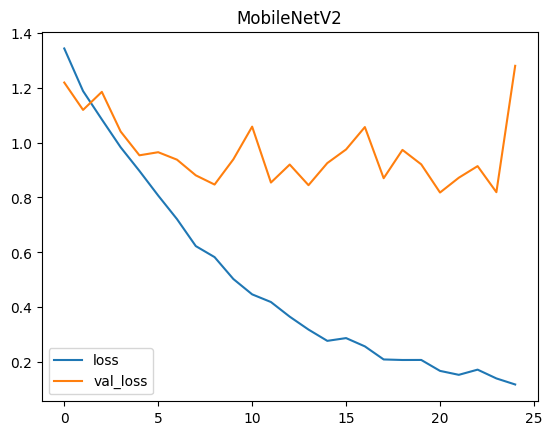

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# loss
fig, ax = plt.subplots()
ax.plot(h_model.history['loss'], label='loss')
ax.plot(h_model.history['val_loss'], label='val_loss')
ax.legend()
plt.title('MobileNetV2')
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\MobileNetV2Loss.png')

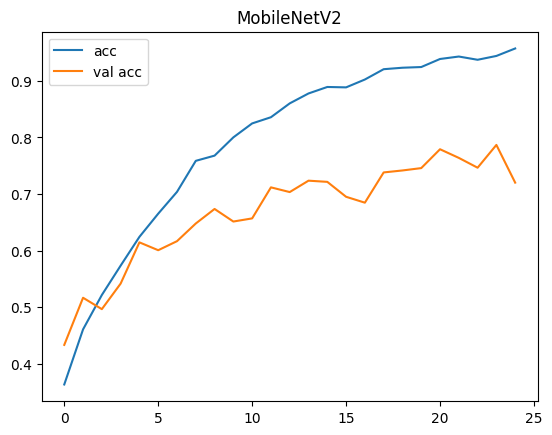

In [21]:
# accuracies
fig, ax = plt.subplots()
ax.plot(h_model.history['accuracy'], label='acc')
ax.plot(h_model.history['val_accuracy'], label='val acc')
ax.legend()
plt.title('MobileNetV2')
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\MobileNetV2Accuracy.png')

In [22]:
# Simpan model
model.save(r"D:\Users\RESA\Coding\Evaluasi\MobileNetV2.h5")

In [23]:
y_preds =  model.predict(X_test_rgb)
y_preds

array([[9.43455160e-01, 5.33020645e-02, 3.23582371e-03, 7.02109492e-06],
       [2.40591307e-05, 9.95125711e-01, 4.77474276e-03, 7.54410139e-05],
       [7.97449102e-05, 5.19632067e-07, 9.99919295e-01, 4.80251231e-07],
       ...,
       [9.99813855e-01, 6.79993784e-10, 6.65317584e-12, 1.86134697e-04],
       [1.29284775e-02, 3.49242357e-03, 1.46819368e-09, 9.83579099e-01],
       [1.86205178e-03, 9.08920288e-01, 9.46795102e-04, 8.82708728e-02]],
      dtype=float32)

In [24]:
y_preds_ind = np.argmax(y_preds,axis=1)
y_preds_ind

array([0, 1, 2, ..., 0, 3, 1], dtype=int64)

In [25]:
qwe=np.argmax(Y_test, axis=1)

In [26]:
confusion_matrix(qwe,y_preds_ind)

array([[338,   8,  17,  17],
       [ 54, 170,  52,  62],
       [ 48,   4, 255,  56],
       [ 61,   1,  23, 274]], dtype=int64)

In [27]:
print(classification_report(qwe,y_preds_ind))

              precision    recall  f1-score   support

           0       0.67      0.89      0.77       380
           1       0.93      0.50      0.65       338
           2       0.73      0.70      0.72       363
           3       0.67      0.76      0.71       359

    accuracy                           0.72      1440
   macro avg       0.75      0.71      0.71      1440
weighted avg       0.75      0.72      0.71      1440



In [28]:
model.evaluate(X_test_rgb, Y_test)

45/45 [==============================] - 16s 351ms/step - loss: 1.2793 - accuracy: 0.7201 - specificity: 0.9116 - sensitivity: 0.7125


[1.279334545135498, 0.7201389074325562, 0.9115740656852722, 0.7124999761581421]

### 6.3 ROC AUC Curve

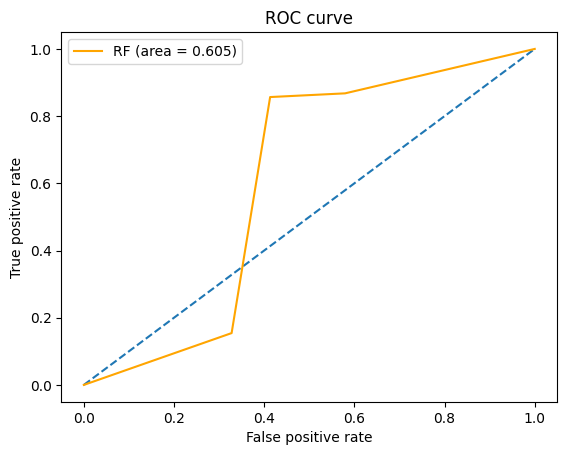

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(qwe, y_preds_ind, pos_label=2)

auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1],"--")

plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc), color='orange')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Visualization

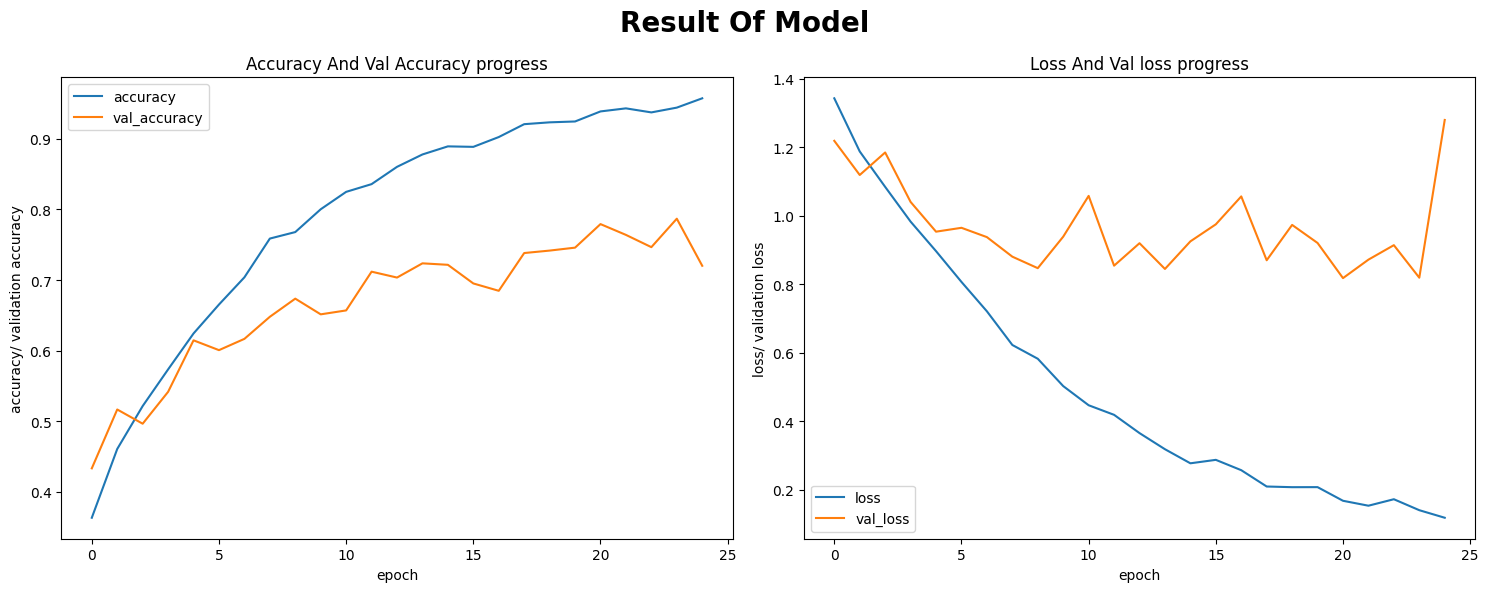

In [30]:
def Visualize_Result(acc,val_acc,loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6))

    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')

    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')
    
    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')
    
    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\Accuracy_Loss_figure_ResNet50.png')
    plt.tight_layout()
    plt.show()

visualize_result = Visualize_Result(h_model.history['accuracy'],h_model.history['val_accuracy'], h_model.history['loss'], h_model.history['val_loss'])

## 7. Cross Validation

In [31]:
# Set early stopping criteria
pat = 5 
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

# Tentukan model checkpoint callback
model_checkpoint = ModelCheckpoint(r'D:\Users\RESA\Coding\Evaluasi\h_MobileNetV2.h5', verbose=1, save_best_only=True)

# Tentukan fungsi untuk fit model
def fit_and_evaluate(X_train_rgb, X_test_rgb, Y_train, Y_test, EPOCHS=20, BATCH_SIZE=16):
    model = create_model()
    results = model.fit(X_train_rgb, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        callbacks=[early_stopping, model_checkpoint], verbose=1, validation_split=0.2)
    print("Val Score: ", model.evaluate(X_test_rgb, Y_test))
    return results

### 7.1 Training

In [32]:
n_folds = 5
epochs = 20
batch_size = 16

# Inisialisasi KFold
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Simpan riwayat model
model_history = []

# Loop melalui setiap lipatan
for fold, (train_index, test_index) in enumerate(kf.split(X, np.argmax(Y, axis=1))):
    print(f"Training on Fold: {fold + 1}")
    
    # Pisahkan data menjadi data latih dan uji
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Ubah bentuk input untuk lipatan saat ini
    X_train_rgb_fold = np.expand_dims(X_train, axis=-1)
    X_test_rgb_fold = np.expand_dims(X_test, axis=-1)
    X_train_rgb_fold = np.repeat(X_train_rgb_fold, 3, axis=-1)
    X_test_rgb_fold = np.repeat(X_test_rgb_fold, 3, axis=-1)

    # Panggil fungsi fit_and_evaluate untuk setiap lipatan
    fold_history = fit_and_evaluate(X_train_rgb_fold, X_test_rgb_fold, Y_train, Y_test, epochs, batch_size)
    
    # Simpan riwayat lipatan
    model_history.append(fold_history)
    
    # Pembersihan manual
    gc.collect()
    
    print("=======" * 12, end="\n\n\n")

Training on Fold: 1
Epoch 1/20
288/288 [==============================] - 71s 239ms/step - loss: 1.3500 - accuracy: 0.3980 - val_loss: 3.7665 - val_accuracy: 0.0122

Epoch 00001: val_loss improved from inf to 3.76650, saving model to D:\Users\RESA\Coding\Evaluasi\h_MobileNetV2.h5
Epoch 2/20
288/288 [==============================] - 65s 227ms/step - loss: 1.0045 - accuracy: 0.5472 - val_loss: 5.3750 - val_accuracy: 0.0017

Epoch 00002: val_loss did not improve from 3.76650
Epoch 3/20
288/288 [==============================] - 65s 225ms/step - loss: 0.8785 - accuracy: 0.6238 - val_loss: 4.4829 - val_accuracy: 0.0373

Epoch 00003: val_loss did not improve from 3.76650
Epoch 4/20
288/288 [==============================] - 65s 225ms/step - loss: 0.7892 - accuracy: 0.6639 - val_loss: 6.1977 - val_accuracy: 0.0148

Epoch 00004: val_loss did not improve from 3.76650
Epoch 5/20
288/288 [==============================] - 65s 226ms/step - loss: 0.7238 - accuracy: 0.7029 - val_loss: 7.0212 - val_

### 7.2 Evaluasi Cross - Validation

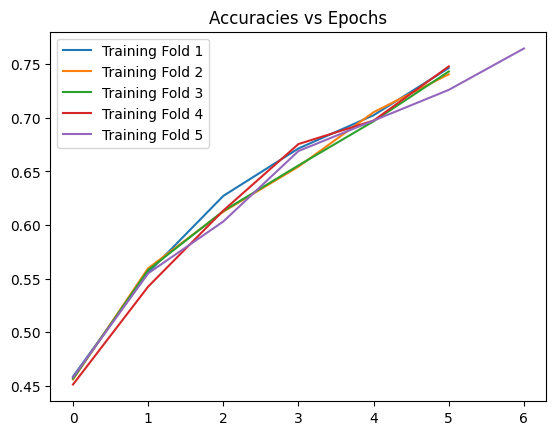

In [33]:
plt.title('Accuracies vs Epochs')
for i in range(len(model_history)):
  plt.plot(model_history[i].history['accuracy'], label=f"Training Fold {i+1}")

plt.legend()
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\Accuracy_vs_Epoch_MobileNetV2.png')

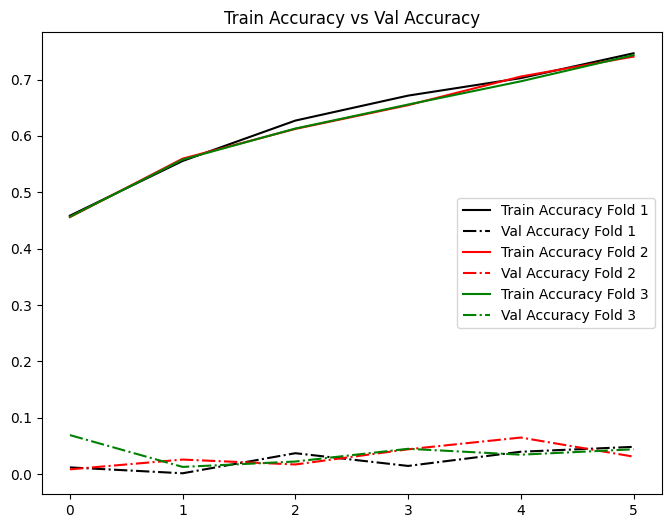

In [34]:
plt.figure(figsize=(8,6))
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\TrainAccuracy_vs_ValAccuracy_MobileNetV2.png')

In [35]:
y_preds =  model.predict(X_test_rgb_fold)
y_preds

array([[1.00000000e+00, 3.97384348e-08, 6.02098638e-09, 3.60499097e-09],
       [1.00688925e-02, 2.48812171e-07, 1.40450889e-11, 9.89930868e-01],
       [9.99987245e-01, 4.89896706e-07, 2.49666300e-07, 1.20415325e-05],
       ...,
       [1.56337351e-01, 5.92394872e-06, 2.93014068e-06, 8.43653738e-01],
       [1.98557251e-03, 4.22676996e-04, 2.98786849e-01, 6.98804915e-01],
       [5.66836570e-05, 9.92293571e-05, 3.36342007e-02, 9.66209888e-01]],
      dtype=float32)

In [36]:
y_preds_arg = np.argmax(y_preds,axis=1)
y_preds_arg

array([0, 3, 0, ..., 3, 3, 3], dtype=int64)

In [37]:
asd = np.argmax(Y_test, axis=1)
asd

array([0, 0, 0, ..., 3, 3, 3], dtype=int64)

In [38]:
confusion_matrix(asd,y_preds_arg)

array([[354,   1,   1,   4],
       [ 48, 255,  26,  31],
       [ 16,   1, 321,  22],
       [ 21,   0,   6, 333]], dtype=int64)

In [39]:
print(classification_report(asd,y_preds_arg))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89       360
           1       0.99      0.71      0.83       360
           2       0.91      0.89      0.90       360
           3       0.85      0.93      0.89       360

    accuracy                           0.88      1440
   macro avg       0.89      0.88      0.87      1440
weighted avg       0.89      0.88      0.87      1440



In [40]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,fmt='g', cmap="viridis")
    plt.show()

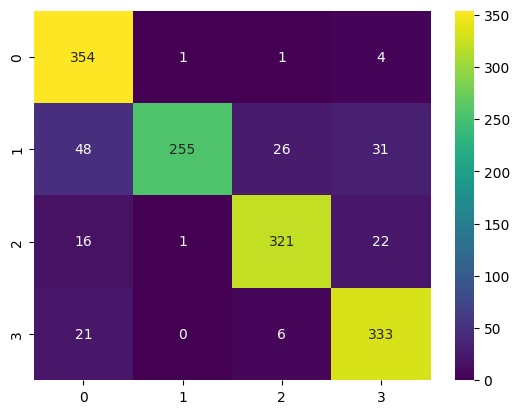

In [41]:
draw_confusion_matrix(asd,y_preds_arg)